Much of this lecture follows the free textbook by Rob Hyndman, [Forecasting Principles and Practice](https://otexts.org/fpp2/)

## Objectives

By the end of the day you should be able to:

  - Define "time series" and "time-series data".
  - Identify fundamental concepts in a time series: trend, seasonality, stickyness.
  - Use the classical decomposition to decompose and then describe a time series.
  - Define stationarity, contrast with independence.
  - Identify a stationary time series.
  - Fit ARIMA models to forecast a stationary time series.

## Agenda

#### Morning
 * Some examples
 * Trend
 * Seasonality


#### Afternoon
 * White noise & Stationarity
 * Differencing
 * Random walks
 * MA series
 * Autocorrelation
 * Partial autocorrelation
 * Autoregressive series
 * ARIMA models
 * Model selection

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
from scipy import stats

# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.style.use('ggplot')

In [2]:
def load_google_trend_data(name):
    """Load saved data for a google trend.
    
    NOTE: For this to work you need to have started your notebook from the
    lecture directory.
    """
    file_name = 'data/{}'.format(''.join(['search-index-', name, '.txt']))
    df = pd.read_csv(file_name)
    df = df.set_index(pd.DatetimeIndex(df.week))
    del df['week']
    return pd.Series(df[name], df.index)

In [3]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series, marker='.')
    ax.set_title("Google Search Trend For {}".format(name))

In [4]:
google_search_names = ['baseball', 'python', 'pokemon', 'taxes', 'gdp', 'gmail', 'blackberry', 'data-science']

google_trends = {
    name: load_google_trend_data(name)
    for name in google_search_names
}

# Time Series - Statistical Models

So far we've just been throwing linear regression at these time series, despite the fact that its most basic assumptions (such as "independent samples") are grossly violated. If we want to make any kind of statistical inference, we need to build an appropriate statistical model from scratch.

## Statistical Concepts

### Random Processes

Up to now we have only considered a single manifestation of a single time series

$$ y_1, y_2, y_3, \ldots $$

Let's now impose a probability model on this data, i.e., now we consider series as **random objects that can be sampled**.

Formally, we consider a single time series as a *sample* from a sequence of random variables

$$ Y_1, Y_2, Y_3, \ldots $$

Note that we are **not** assuming that these random variables are independent, **it is very likely that in a time series that sample we draw at time $t$ influences the sample we draw at time $t+1$**.

When we need to distinguish the data from the statistical model that we are assuming generated the data, we call:

  - The data a **series**.
  - The data generating process a **random process**, or more specifically, a **time series random process**.

### White Noise

The simplest possible random process from this perspective occurs when each $Y_i$ is independent from all the rest, and all the $Y$'s are identically distributed.

In this case the series is called **white noise**.

In [5]:
def gaussian_white_noise(size=250):
    return pd.Series(np.random.normal(size=size))

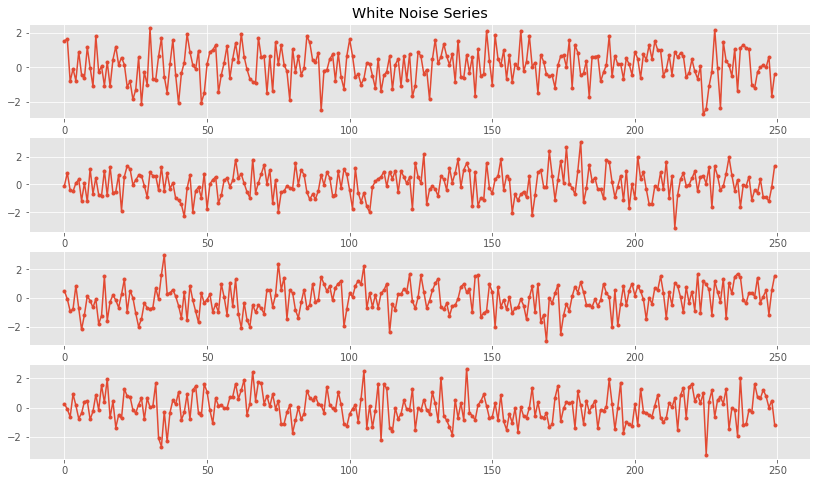

In [6]:
fig, axs = plt.subplots(4, figsize=(14, 8))
for i in range(4):
    noise = gaussian_white_noise()
    axs[i].plot(noise.index, noise, marker='.')
    if i == 0:
        axs[i].set_title("White Noise Series")

White noise shows no trend, no seasonal patterns, and no stickiness.

### Stationarity

White noise has the simplest possible structure: every observation is drawn from independent, identical distributions.

As mentioned, in most time series observations will **not** be independent.  Nonetheless, there is a useful concept that characterizes the type of dependence found in many time series.

A time series random process $Y_1, Y_2, Y_3, \ldots$ is said to be **strictly stationary** if the distribution of all equally spaced tuples taken from the series are identical.  That is, if the **joint distribution** of

$$ (Y_{i_1}, Y_{i_2}, \ldots, Y_{i_n}) $$

is identical to the **joint distribution** of 

$$ (Y_{i_1 + k}, Y_{i_2 + k}, \ldots, Y_{i_n + k}) $$


**This means that** the properties of the series **do not** depend on when you begin observing it.

**This means that** if you start observing the series, watch for an hour, go cook a meal for an hour, then watch the series for another hour, **it does not matter if the meal you cooked was breakfast, lunch, or dinner**. The properties of the series you observe will be the same in any case.

**This means that** the distribution of $Y_{i}$ and the distribution of $Y_{i+k}$ must be identical, for any $k$. Thus, strict stationarity implies that the ***mean*** and ***variance*** are constant over time. 

Here are a few series that **violate** stationarity: the distribution that produces each point is changing over time.

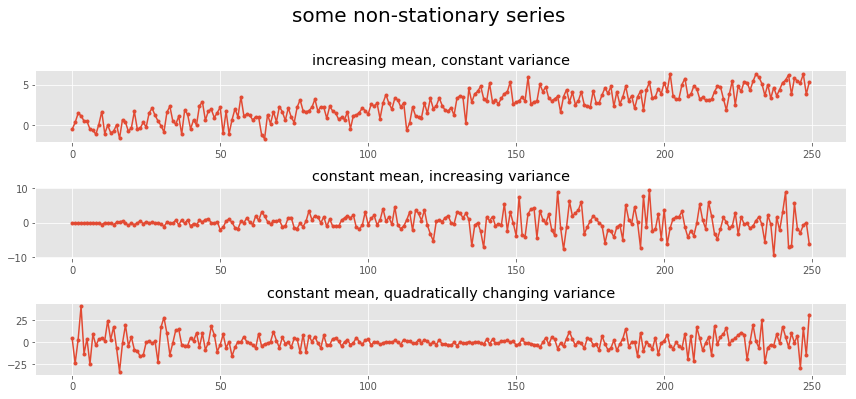

In [7]:
xpts = np.arange(250)
fig, ax = plt.subplots(3, figsize=(12,5))

ypts = stats.norm(xpts/50, 1).rvs(250)
ax[0].plot(xpts, ypts, marker='.')
ax[0].set_title('increasing mean, constant variance')

ypts = stats.norm(0, xpts/50).rvs(250)
ax[1].plot(xpts, ypts, marker='.')
ax[1].set_title('constant mean, increasing variance')


ypts = stats.norm(0, ((xpts-125)**2)/800 + 2).rvs(250)
ax[2].plot(xpts, ypts, marker='.')
ax[2].set_title('constant mean, quadratically changing variance')

fig.suptitle("some non-stationary series", y=1.1, fontsize=20)
fig.tight_layout()

Here's another example that **violates** stationarity: each point is drawn from the same distribution, but the *covariance* between points $Y_i$ and $Y_{i+1}$ changes over time. The covariance between a time series and itself lagged by $k$ is called the *autocovariance*.

(For details on how this was generated, ask Moses)

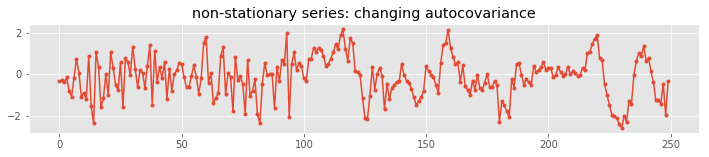

In [8]:
fig, ax = plt.subplots(figsize=(12,2))
ypts = stats.norm(0,1).rvs(250)

# for each point from 100 on, let's
# add the next four points.
# this means each point from 100 on
# is the sum of 5 independent normal
# random variables with mean 0, 
# which we can show is also a 
# normal random variable with mean 0.
ypts[100:-4] += (ypts[101:-3] + 
                 ypts[102:-2] + 
                 ypts[103:-1] + 
                 ypts[104:])

# we just need to rescale it
# back to variance 1
ypts[100:-4] /= 5**.5
ax.plot(xpts, ypts, marker='.')
ax.set_title("non-stationary series: changing autocovariance");

**Discussion:** Can stationary series show trends?  Can stationary series show seasonality?  Can stationary series be sticky?

**Discussion:** Can the variance of a stationary series change over time?

**Discussion:** Is the following series stationary? No? Summarize all the reasons why not.

In [9]:
file_name = 'data/jj.txt'
df = pd.read_csv(file_name)
earnings_series = pd.Series(df.earnings)

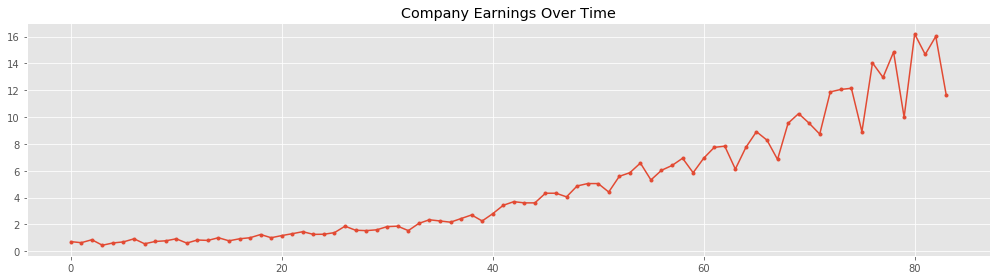

In [10]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(earnings_series.index, 
        earnings_series, marker='.')
ax.set_title("Company Earnings Over Time")
fig.tight_layout()

**Question:** How would you transform this series to be stationary?
  - How would you remove the trend?
  - How would you stabilize the variance?  [This may help](http://stats.stackexchange.com/questions/18930/transformation-for-stabilizing-variance-in-time-series).

### Differencing

Most series encountered in nature are **not** stationary, but there is often a simple way to transform one to be stationary.

Given a time series $y_1, y_2, y_3, \ldots$, the **first differences series** is

$$ y_2 - y_1, y_3 - y_2, y_4 - y_3, \ldots $$

The aim of differencing a series is to remove the trend component, which stationary series cannot have.

In [11]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series, marker='.')
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff, marker='.')
    axs[1].set_title("Series of First Differences: {}".format(title))

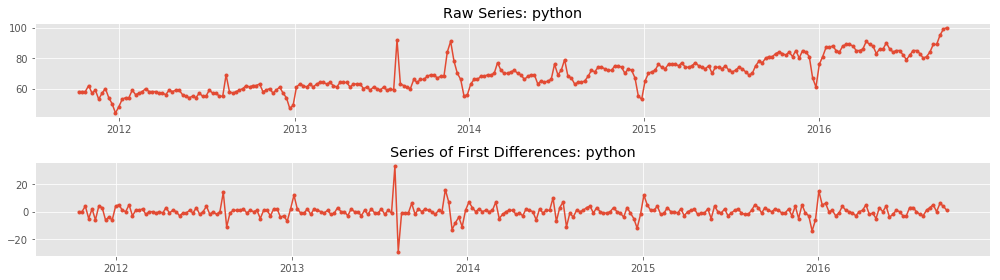

In [12]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, google_trends['python'], 'python')
fig.tight_layout()

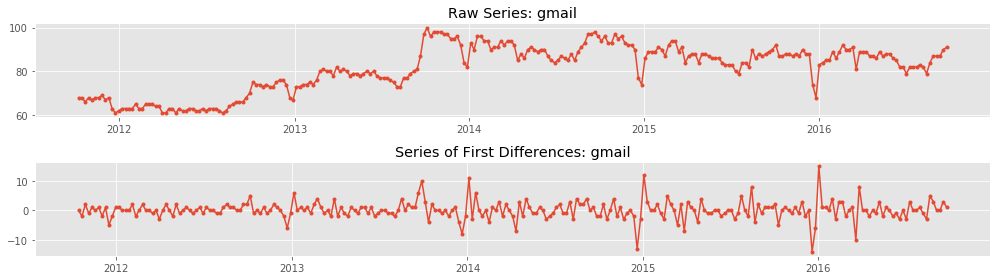

In [13]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, google_trends['gmail'], 'gmail')
fig.tight_layout()

**Discussion:** Do these difference series look stationary?

**Activity:** Compute and plot the first differences series for data science.  Does it look stationary?

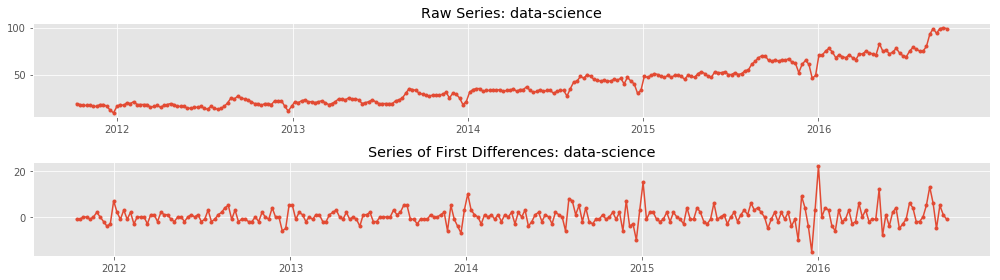

In [14]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, google_trends['data-science'], 'data-science')
fig.tight_layout()

**Question:** If you are given the *differences* of a series, how can you recover the original series?

### Example: Random Walks

When a differenced series is *white noise* (**note**: *not all stationary series are white noise*, as we will demonstrate below) we have the following relationship

$$ y_{i+1} - y_i = w_i $$

or 

$$ y_{i+1} = y_i + w_i $$

This type of series is called a **random walk** and is a very common statistical model for time series.

In [15]:
def random_walk(size=250):
    noise = np.random.normal(size=(size + 1))
    walk = np.cumsum(noise)
    return pd.Series(walk)

In [16]:
def plot_random_walk(ax, size=250):
    walk = random_walk(size=size)
    ax.plot(walk.index, walk, marker='.')

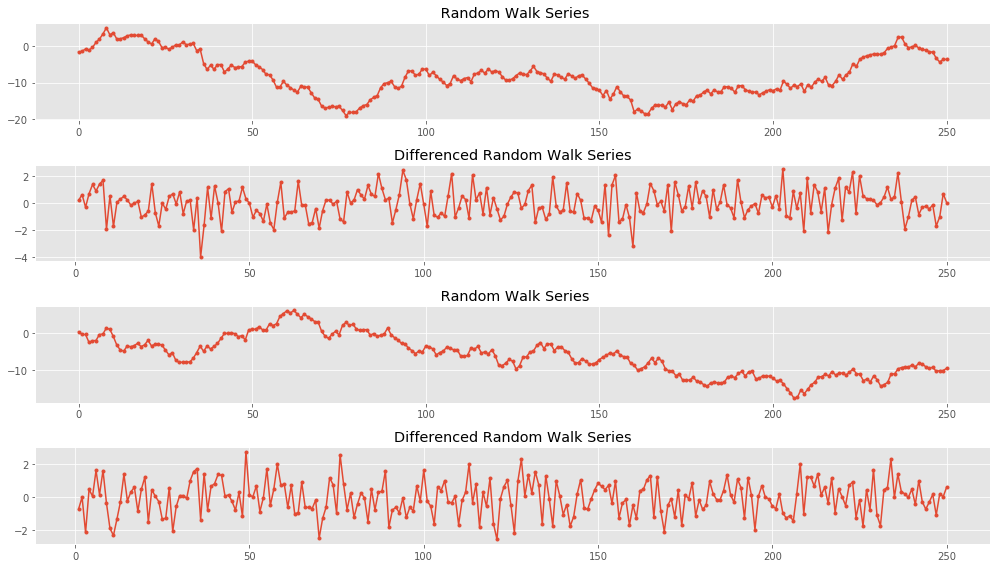

In [17]:
fig, axs = plt.subplots(4, figsize=(14, 8))
for i in [0,2]:
    walk = random_walk()
    diff = walk.diff()
    axs[i].plot(walk.index, walk, marker='.')
    axs[i].set_title(" Random Walk Series")
    axs[i + 1].plot(diff.index, diff, marker='.')
    axs[i + 1].set_title("Differenced Random Walk Series") 
plt.tight_layout()

Notice that random walks, although constructed from totally random components, can show very strong evidence of *trends*.  This is because random walks are sticky, once they randomly elevate to an extreme value, subsequent values of the series are only small adjustments to previous values, so the value of the series tends to stay elevated.

**Question:** Is the differenced series from a random walk white noise?

### Example: Linear Combinations of White Noise

We saw a lot of non-stationary series above. So far, the only stationary series we've seen is pure white noise. What other kinds of stationary series exist?

A simple way to construct a diverse set of stationary series is as **linear combinations of white noise**.

Suppose that 

$$ w_1, w_2, w_3, \ldots $$

is a white noise process (what was that again?).  Then any series created by linearly combining lagged values of $w$ is stationary

$$ y_i = \mu + w_i + a_1 w_{i-1} + a_2 w_{i-2} + \cdots + a_k w_{i-k} $$

Consider a simple case where $\mu=0$, $a_1 = 1$ and all other coefficients are zero:
$$y_i = w_i + w_{i-1}$$

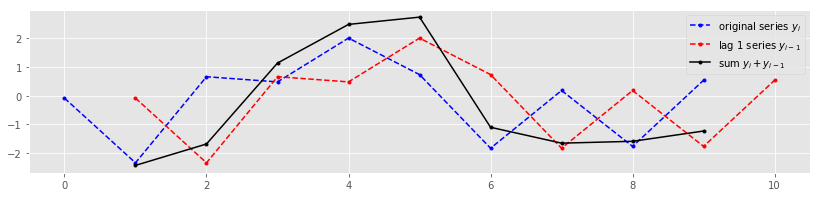

In [18]:
noise = gaussian_white_noise(size=10).values
index = np.array(range(len(noise)))

fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(index, noise, 'b.--', label='original series $y_i$')
ax.plot(index+1, noise, 'r.--', label='lag 1 series $y_{i-1}$')
ax.plot(index[:-1]+1, noise[1:] + noise[:-1], 'k.-', label='sum $y_i + y_{i-1}$')
ax.legend();

In [19]:
def linear_combination_of_white_noise(size, coefs):
    n_coefs = len(coefs)
    noise_size = size + len(coefs)
    noise = np.random.normal(size=noise_size)
    
    lin_comb = noise.copy()
    for k, coef in enumerate(coefs, start=1):
        lin_comb[k:] += coef*noise[:-k]    
    return pd.Series(lin_comb[n_coefs:])

In [20]:
def plot_linear_combination_of_white_noise(ax, size, coef):
    series = linear_combination_of_white_noise(size, coef)
    ax.plot(series.index, series, marker='.')
    ax.set_title("Linear Combination of White Noise with Coefficients {}".format(
            str(list(coef))))

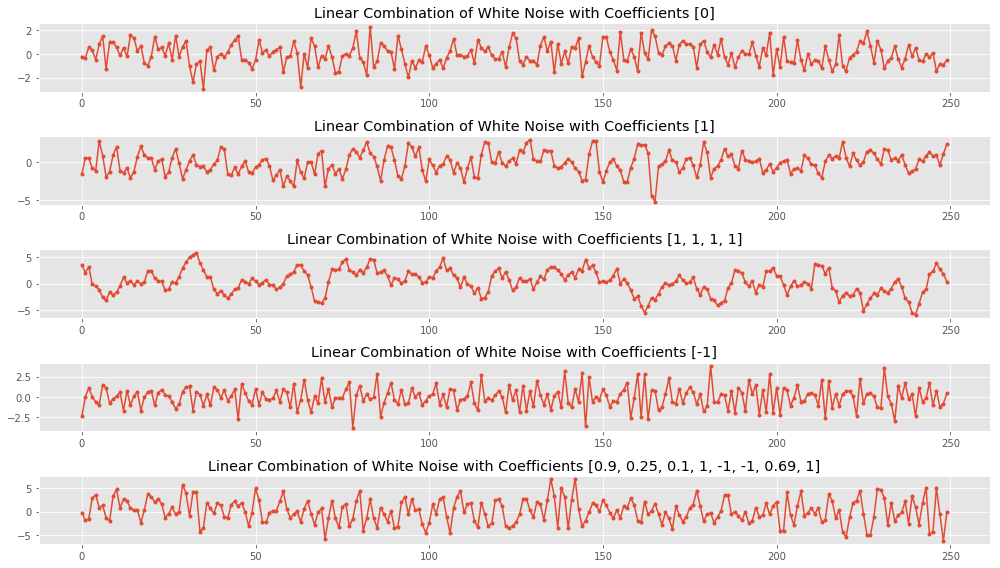

In [21]:
fig, axs = plt.subplots(5, figsize=(14, 8))
plot_linear_combination_of_white_noise(axs[0], 250, [0])
plot_linear_combination_of_white_noise(axs[1], 250, [1])
plot_linear_combination_of_white_noise(axs[2], 250, [1,1,1,1])
plot_linear_combination_of_white_noise(axs[3], 250, [-1])
plot_linear_combination_of_white_noise(axs[4], 250, [0.9, 0.25, 0.1, 1,
                                                    -1, -1, 0.69, 1])
plt.tight_layout()

**All the series above are sampled from stationary processes.**

A linear combination of white noise is traditionally called an **MA series**.

  - An MA(1) contains one lagged term: $y_i = \mu + w_i + a_1 w_{i-1}$
  - An MA(2) contains two lagged terms: $y_i = \mu + w_i + a_1 w_{i-1} + a_2 w_{i-2}$
  - And so on...
  
**Note:**  MA stands for *moving average*, even though this has *almost nothing to do with* moving average smoothing as we discussed earlier.  Unfortunately, the name has stuck, and you'll have to get use to it.  My recommendation is to call them "em ay" series, and reserve the full words for true moving averages.

**Activity:** Take a few minutes to play around with generating some MA series.  Can you create any interesting behavior out of pure randomness?

### Tests for Stationarity

Stationarity can be hard to visualize, so there are some statistical hypothesis tests that you can use to indicate stationarity.

The **Augmented Dickey-Fuller test** is setup as follows:

  - $H_0$: The series is **not-stationary**.
  - $H_{\text{a}}$: The series is stationary.
  
It is available in stats models as [`tsa.stattools.adfuller`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).

White noise series are stationary:

In [22]:
for i in range(5):
    test = sm.tsa.stattools.adfuller(gaussian_white_noise(size=250))
    print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.00
ADF p-value: 0.00
ADF p-value: 0.00
ADF p-value: 0.00
ADF p-value: 0.00


MA series are stationary:

In [23]:
for coef in [[1], [-1], [1, 1, 1, 1], [0.5, 0.25, 0.1]]:
    series = linear_combination_of_white_noise(250, coef)
    test = sm.tsa.stattools.adfuller(series)
    print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.00
ADF p-value: 0.00
ADF p-value: 0.06
ADF p-value: 0.00


The random walk $ y_{i+1} = y_i + w_i $ is not stationary

In [24]:
test = sm.tsa.stattools.adfuller(random_walk(size=250))
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.54


What about some of the series we found in nature?

The python series has an obvious trend, it is clearly not stationary, and the test confirms.

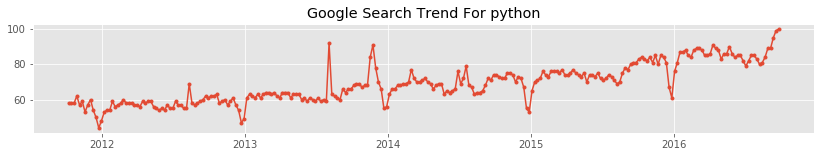

In [25]:
fig, ax = plt.subplots(figsize=(14,2))
plot_trend_data(ax, 'python', load_google_trend_data('python'))

In [26]:
test = sm.tsa.stattools.adfuller(google_trends['python'])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.95


Maybe differencing helps?

In [27]:
python_diffed = google_trends['python'].diff()[1:]

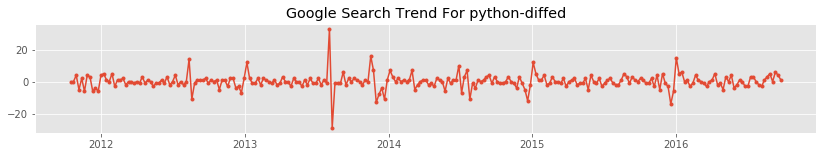

In [28]:
fig, ax = plt.subplots(figsize=(14,2))
plot_trend_data(ax, 'python-diffed', python_diffed)

In [29]:
test = sm.tsa.stattools.adfuller(python_diffed)
print("ADF p-value for differenced python series: {0:2.2f}".format(test[1]))

ADF p-value for differenced python series: 0.00


### **It sure did!**

According to the ADF test, the baseball series is also stationary after differencing. This is because the ADF test is blind to seasonality when there are many seasons present. 

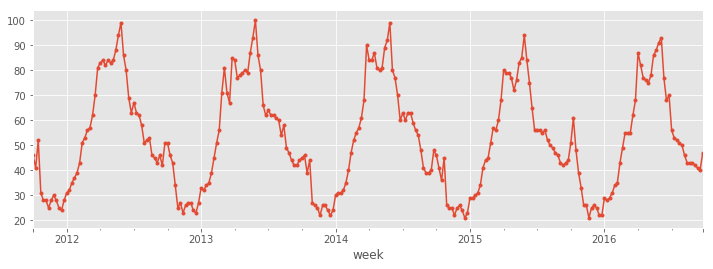

In [30]:
google_trends['baseball'].plot(figsize=(12,4), marker='.');

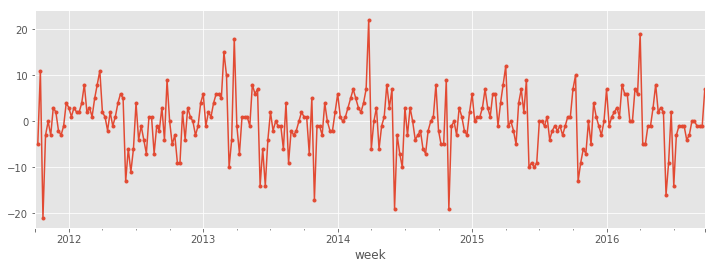

In [31]:
google_trends['baseball'].diff().plot(figsize=(12,4), marker='.');

In [32]:
test = sm.tsa.stattools.adfuller(google_trends['baseball'])
print("ADF p-value for baseball series: {0:2.2f}".format(test[1]))

ADF p-value for baseball series: 0.00


In [33]:
test = sm.tsa.stattools.adfuller(google_trends['baseball'].diff()[1:])
print("ADF p-value for differenced baseball series: {0:2.2f}".format(test[1]))

ADF p-value for differenced baseball series: 0.00


In [34]:
bsb = google_trends['baseball']

In [35]:
bsb.head()

week
2011-10-08    46
2011-10-15    41
2011-10-22    52
2011-10-29    31
2011-11-05    28
Name: baseball, dtype: int64

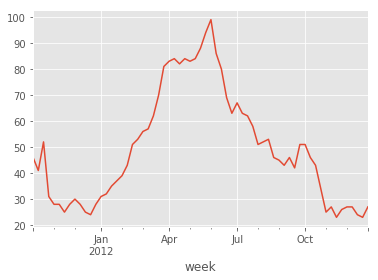

In [36]:
bsb.loc[:'2012'].plot()

In [37]:
test = sm.tsa.stattools.adfuller(bsb.loc[:'2012'])
print("ADF p-value for baseball series: {0:2.2f}".format(test[1]))

ADF p-value for baseball series: 0.77


In [38]:
bsb.head()

week
2011-10-08    46
2011-10-15    41
2011-10-22    52
2011-10-29    31
2011-11-05    28
Name: baseball, dtype: int64

In [39]:
bsb.loc[:'2012'].diff()[1:].head()

week
2011-10-15    -5.0
2011-10-22    11.0
2011-10-29   -21.0
2011-11-05    -3.0
2011-11-12     0.0
Name: baseball, dtype: float64

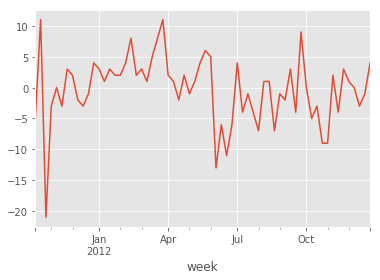

In [40]:
bsb.loc[:'2012'].diff()[1:].plot()

In [41]:
test = sm.tsa.stattools.adfuller(bsb.loc[:'2012'].diff()[1:])
print("ADF p-value for baseball series: {0:2.2f}".format(test[1]))

ADF p-value for baseball series: 0.00


**Activity:** Test some of the other series we've been experimenting with for stationarity.  Does differencing improve the situation?

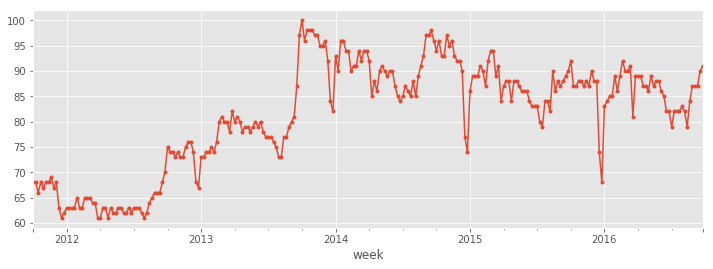

In [42]:
google_trends['gmail'].plot(figsize=(12,4), marker='.');

In [43]:
test = sm.tsa.stattools.adfuller(google_trends['gmail'])
print("ADF p-value for gmail series: {0:2.2f}".format(test[1]))

ADF p-value for gmail series: 0.25


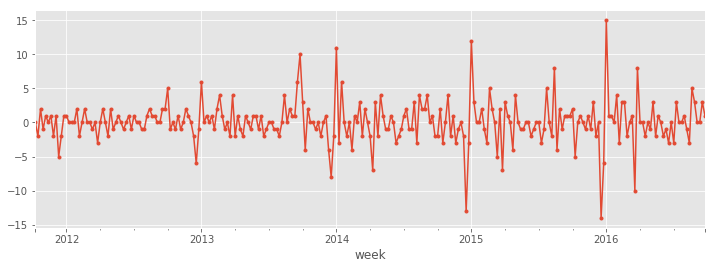

In [44]:
google_trends['gmail'].diff()[1:].plot(figsize=(12,4), marker='.');

In [45]:
test = sm.tsa.stattools.adfuller(google_trends['gmail'].diff()[1:])
print("ADF p-value for differenced gmail series: {0:2.2f}".format(test[1]))

ADF p-value for differenced gmail series: 0.00


**Activity:** Can you transform the `earnings` series from earlier to be stationary?  There is a step you will have to take that we have **not** discussed.

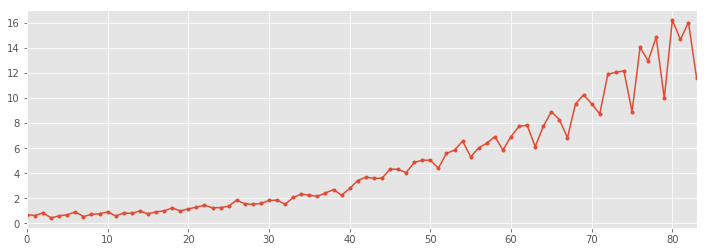

In [46]:
earnings_series.plot(figsize=(12,4), marker='.');

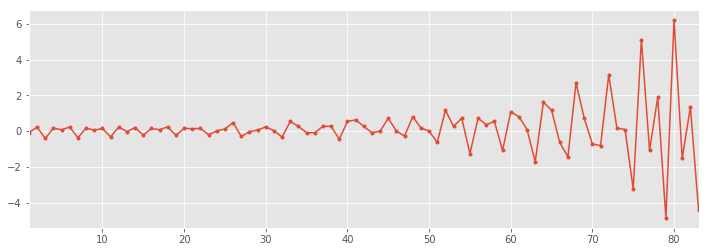

In [47]:
earnings_diff = earnings_series.diff()[1:]
earnings_diff.plot(figsize=(12,4), marker='.');

In [48]:
test = sm.tsa.stattools.adfuller(earnings_diff)
print("ADF p-value for differenced earnings series: {0:2.2f}".format(test[1]))

ADF p-value for differenced earnings series: 0.91


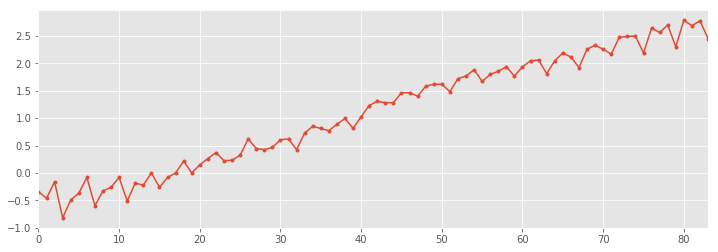

In [49]:
log_earn = np.log(earnings_series)
log_earn.plot(figsize=(12,4), marker='.');

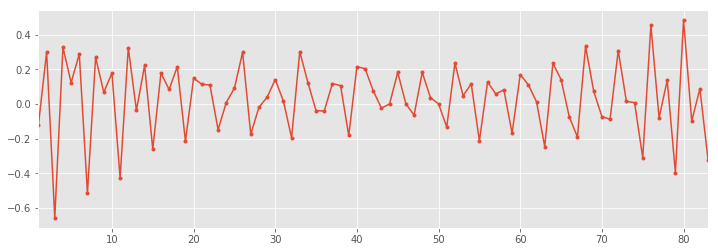

In [50]:
log_earn = np.log(earnings_series)
log_earn_diff = log_earn.diff()[1:]
log_earn_diff.plot(figsize=(12,4), marker='.');

In [51]:
test = sm.tsa.stattools.adfuller(log_earn_diff)
print("ADF p-value for differenced log-earnings series: {0:2.2f}".format(test[1]))

ADF p-value for differenced log-earnings series: 0.00


For the rest of the day, we will be working with *stationary* series, and developing a statistical model for them.

## Autocorrelation

Recall the definition of strictly stationary.

A time series $Y_1, Y_2, Y_3, \ldots$ is said to be **strictly stationary** if the distribution of all equally spaced tuples taken from the series are identical.  That is, if

$$ (Y_{i_1}, Y_{i_2}, \ldots, Y_{i_n}) $$

and

$$ (Y_{i_1 + k}, Y_{i_2 + k}, \ldots, Y_{i_n + k}) $$

are always identically distributed.

One consequence of this definition is that the correlation between two $Y$'s only depends on the lag between them:

$$ Corr(Y_5, Y_2) = Corr(Y_4, Y_1) = Corr(Y_{144}, Y_{141}) = \cdots $$

These correlations between a time series and a lagged version of itself are called **autocorrelations**.

$$ \gamma_k(Y)= Corr(Y_1, Y_{1+k}) = Corr(Y_2, Y_{2+k}) = Corr(Y_3, Y_{3+k}) = \cdots $$

In [52]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

def plot_series_and_lagged(axs, series, title, lag=1):
    series.iloc[:-lag].plot(ax=axs[0], marker='.')
    series.iloc[lag:].plot(ax=axs[1], marker='.')
    axs[0].set_title(title)
    axs[1].set_title(title + ' lagged by {}'.format(lag))
    

Recall from earlier that the differenced baseball series **is** stationary (according to the ADF test).

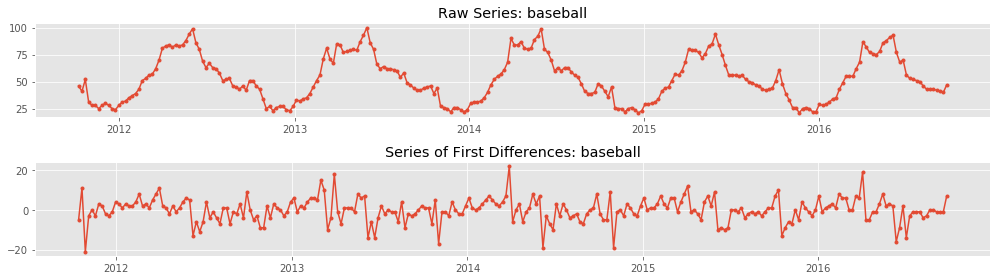

In [53]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, google_trends['baseball'], 'baseball')
fig.tight_layout()

In [54]:
baseball_series = google_trends['baseball']
baseball_diff = baseball_series.diff()[1:]

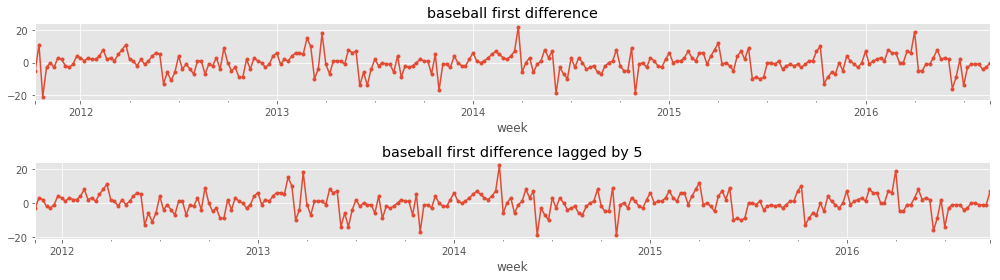

In [55]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_lagged(axs, baseball_diff, 'baseball first difference', lag=5)
fig.tight_layout()

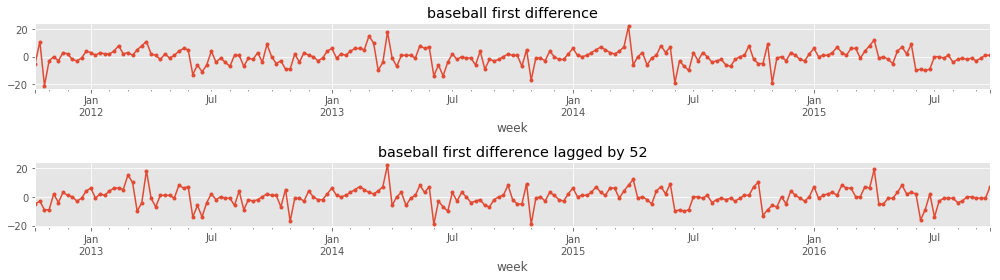

In [56]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_lagged(axs, baseball_diff, 'baseball first difference', lag=52)
fig.tight_layout()

We can draw some scatterplots to summarize the autocorrelation information in the baseball series.

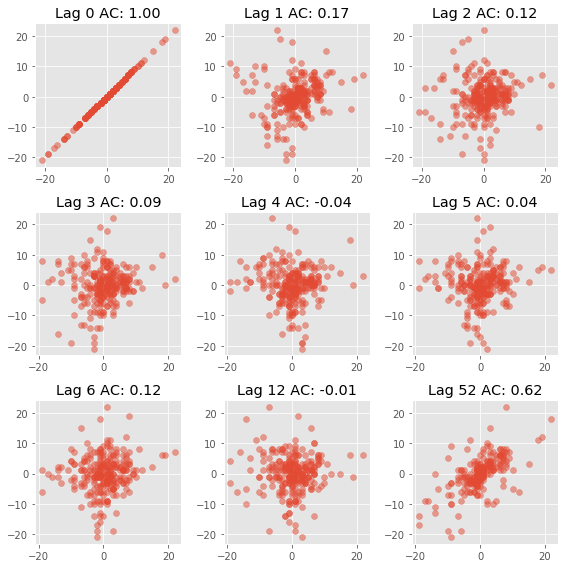

In [57]:
baseball_diff = google_trends['baseball'].diff()[1:]

fig, axs = plt.subplots(3, 3, figsize=(8, 8))

lags = [0,1,2,3,4,5,6,12,52]
for lag, ax in zip(lags, axs.flatten()):
    series, lagged = series_and_lagged(baseball_diff, lag=lag)
    autocorr = compute_autocorrelation(baseball_diff, lag=lag)
    ax.scatter(series, lagged, alpha=0.5)
    ax.set_title("Lag {0} AC: {1:2.2f}".format(lag, autocorr))
    
plt.tight_layout()

**Question:** Why does the first scatterplot here lie along a straight line?

A more immediate way to view the autocorrelation in a series is with an **autocorrelation plot**.  

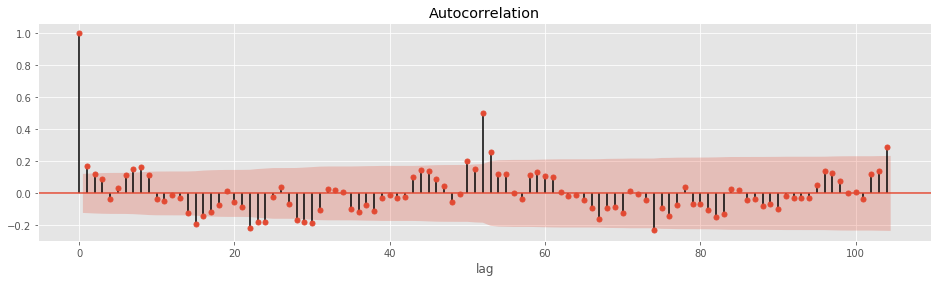

In [58]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(baseball_diff, lags=2*52, ax=ax)
ax.set_xlabel('lag');

The x-axis here is the lag $k$. The value of the autocorrelation at lag $k$ is the correlation between the series $y_t$ and the lagged series $y_{t-k}$

The *first* spike is always at $1.0$ (because any series is perfectly correlated with itself.

The shaded region are 95% confidence bounds.  If *all* of the autocorrelations were truly zero, we would still expect to see about 5% of the spikes exceeding these bounds.

For the baseball example, we observe the following:
  - There is a very striking spike at exactly 52 lags, which is the number of weeks in a year.  This is repeated, less significantly, at a lag of twice 52.
  - The first and 53'rd autocorrelations are positive and significant.

**Discussion:** How do you interpret the large spike in autocorrelation at $52$ weeks?

**Discussion:** Could the spike at $104$ weeks be related to the spike at $52$ weeks?

**Discussion:** Does the spike at 52 weeks *prevent the series from being stationary*?

One potential issue with autocorrelations is the following:
    
If $y_i$ is correlated with $y_{i-1}$ **and** $y_{i-1}$ is correlated with $y_{i-2}$ then $y_{i}$ **necessarily** has some influence on $y_{i-2}$

## Partial Autocorrelation

A **partial autocorrelation** plot controls for this effect. The partial autocorrelation at lag $k$ is the amount of correlation between $y_t$ and $y_{t-k}$ not accounted for by lags $1$ to $k-1$.

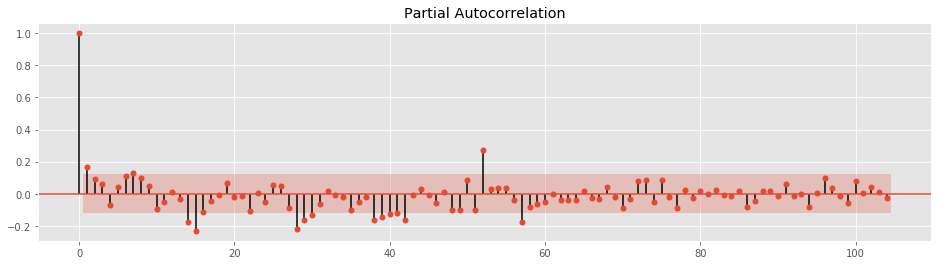

In [59]:
fig, ax = plt.subplots(figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(baseball_diff, lags=2*52, ax=ax, method='ywm')

Here, the spike at $52$ weeks still appears, but the subsequent spike at $104$ weeks has disappeared.  This demonstrates that the spike at $104$ weeks was almost completely caused by the spike at $52$ weeks.

**Discussion:** What would you expect from an autocorrelation plot of white noise?

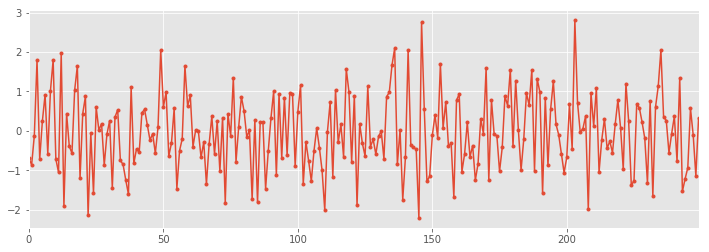

In [60]:
wn = gaussian_white_noise()
wn.plot(figsize=(12,4), marker='.');

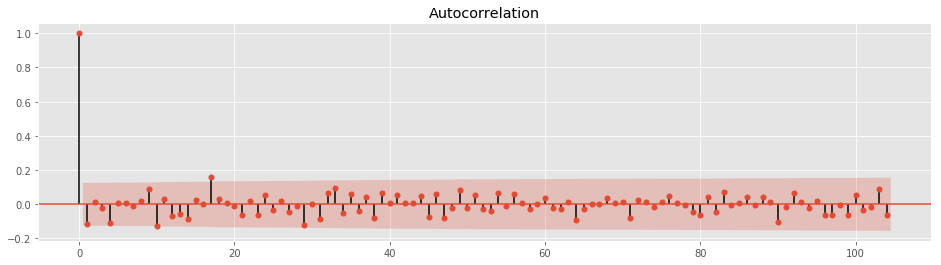

In [61]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(wn, lags=2*52, ax=ax)

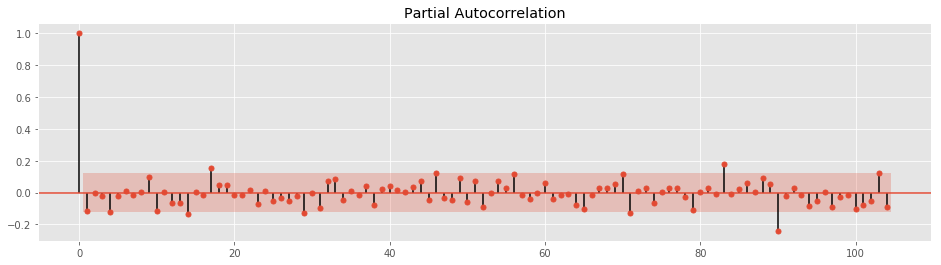

In [62]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(wn, lags=2*52, ax=ax)

### Autocorrelation of MA series

Recall that MA series are linear combinations of white noise with a possible constant term

$$ y_i = \mu + w_i + a_1 w_{i-1} + \cdots + a_k w_{i-k} $$

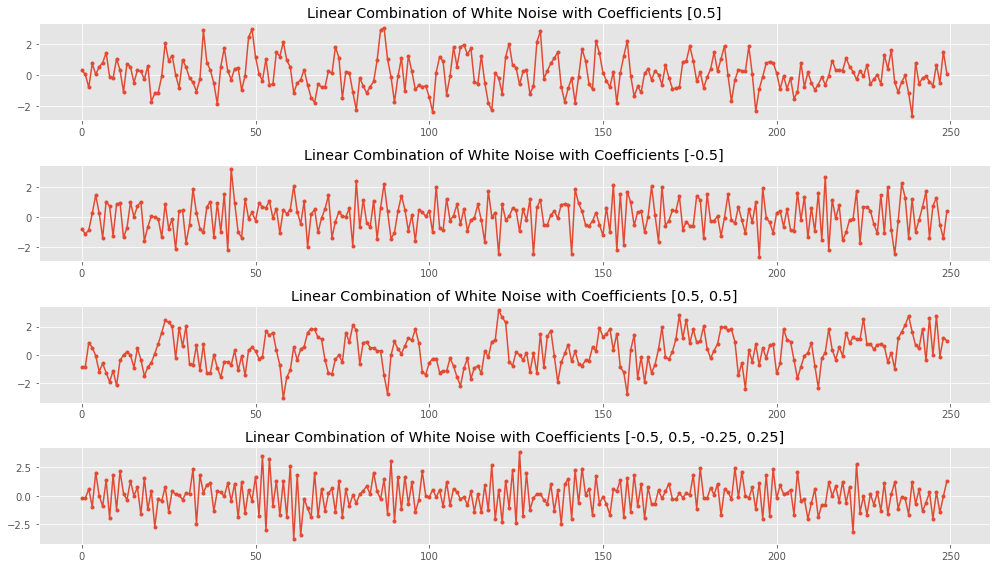

In [63]:
fig, axs = plt.subplots(4, figsize=(14, 8))

ma_coefs = [[0.5], [-0.5], [0.5, 0.5], [-0.5, 0.5, -0.25, 0.25]]
for i, (ax, coef) in enumerate(zip(axs, ma_coefs)):
    plot_linear_combination_of_white_noise(axs[i], 250, coef)

plt.tight_layout()

**Discussion:** What will the autocorrelation of a MA series look like?

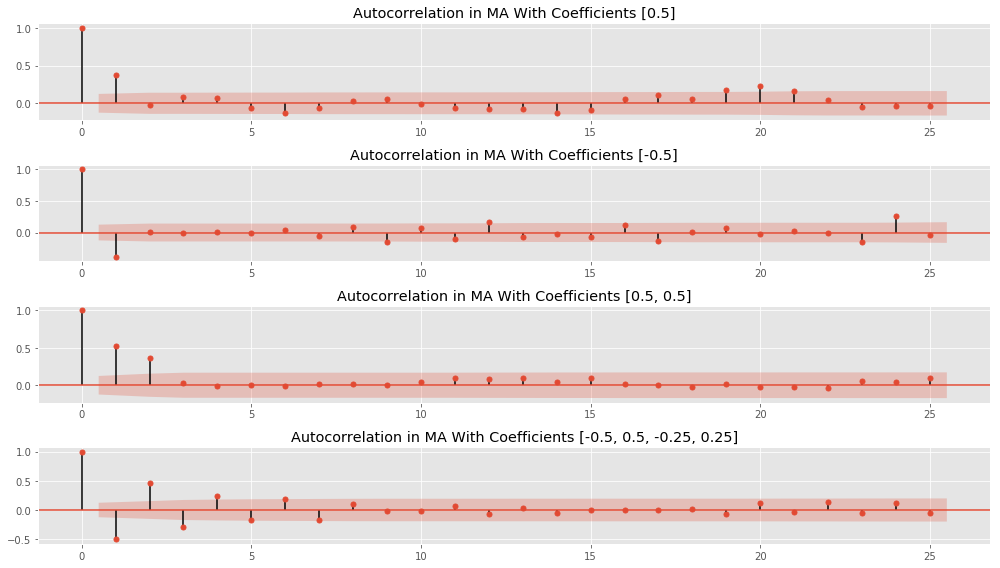

In [64]:
fig, axs = plt.subplots(4, figsize=(14, 8))

for i, (ax, coef) in enumerate(zip(axs, ma_coefs)):
    series = linear_combination_of_white_noise(250, coef)
    _ = sm.graphics.tsa.plot_acf(series, lags=25, ax=ax)
    ax.set_title("Autocorrelation in MA With Coefficients {}".format(str(list(coef))))
    
plt.tight_layout()

### For data generated from an MA model, the number of non-zero autocorrelations generally indicates the *order* of the model (the number of non-zero coefficients).

### MA Models

Given stationary time series data, a reasonable question to ask is the following:
    
> Which MA series would be most likely to generate this data?"

This is the concept behind MA models.

A MA (moving average) model of order $k$ (also known as a $MA(k)$ model) attempts to represent a stationary time series as a linear combination of white noise:

$$ y_i = \mu + w_i + a_1 w_{i-1} + \cdots + a_k w_{i-k} $$

**Discussion:** What technique do you think is used to determine the estimated coefficients when an MA model is fit?

In [65]:
def fit_ma_model(series, order):
    # ARIMA is a more general model, which we are going to build up
    # in pieces.
    model = ARIMA(series, order=(0, 0, order))
    return model.fit()

Let's generate some MA data, fit MA models, and compare the coefficients.

In [66]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [67]:
for coef in ma_coefs:
    ma_series = linear_combination_of_white_noise(250, coef)
    ma_model = fit_ma_model(ma_series.values, order=(len(coef)))
    print("True Coefficients: {0: <20} Estimated Coefficients: {1: <20}".format(
            str(format_list_of_floats(coef)),
            str(format_list_of_floats(ma_model.params[1:]))))

True Coefficients: ['0.50']             Estimated Coefficients: ['0.49']            
True Coefficients: ['-0.50']            Estimated Coefficients: ['-0.51']           
True Coefficients: ['0.50', '0.50']     Estimated Coefficients: ['0.58', '0.58']    
True Coefficients: ['-0.50', '0.50', '-0.25', '0.25'] Estimated Coefficients: ['-0.59', '0.47', '-0.19', '0.20']


So it looks like the MA models recover the true coefficients from *actual* MA processes.  So far, so good.

Before we apply the MA model to real data, we need to introduce AR processes, and generalize everything to the ARIMA model.

### Intermission: Recursive Sequences

A **recursive sequence** (of numbers) is one where the subsequent values in the sequence are defined as functions of the preceding values.  For example:

  - $y_i = 1$
  - $y_i = y_{i-1} + 1; \ y_1 = 0$
  - $y_i = - y_{i-1}; \ y_1 = 1$
  - $y_i = 0.5 y_{i-1} + 0.25 y_{i-2}; \ y_1 = 1; y_2 = 1$

**Activity:** Sketch pictures of these recursive sequences.

**Bonus:**: Write a python function to draw a plot of a recursive sequence.  How should you specify the arguments to this function?  How can you factor the task into multiple functions so that each has a single responsibility?

### AR Processes

Another data generating process that can (often) result in a stationary process is an **autoregressive** process.

In an autoregressive process, subsequent values of the series are linear combinations of previous values of the series plus some noise term (much like in regression we get a linear combination of predictors plus a noise term)

$$ y_i = \mu + b_1 y_{i-1} + b_2 y_{i-2} + \cdots + b_k y_{i-k} + \epsilon_i $$

The number of coefficients in this equation is called the *order* of the model, and we often speak of $AR(1)$ processes, $AR(2)$ processes, etc...

In [68]:
def auto_regressive_process(size, coefs, init=None):
    """Generate an autoregressive process with Gaussian white noise.  The
    implementation is taken from here:
    
      http://numpy-discussion.10968.n7.nabble.com/simulate-AR-td8236.html
      
    Exaclty how lfilter works here takes some pen and paper effort.
    """
    coefs = np.asarray(coefs)
    if init == None:
        init = np.zeros(len(coefs))
    else:
        init = np.asarray(init)
    init = np.append(init, np.random.normal(size=(size - len(init))))
    assert(len(init) == size)
    a = np.append(np.array([1]), -coefs)
    b = np.array([1])
    return pd.Series(signal.lfilter(b, a, init))

In [69]:
def plot_autoregressive_process(ax, size, coefs, init=None):
    ar = auto_regressive_process(size, coefs, init)
    ax.plot(ar.index, ar)

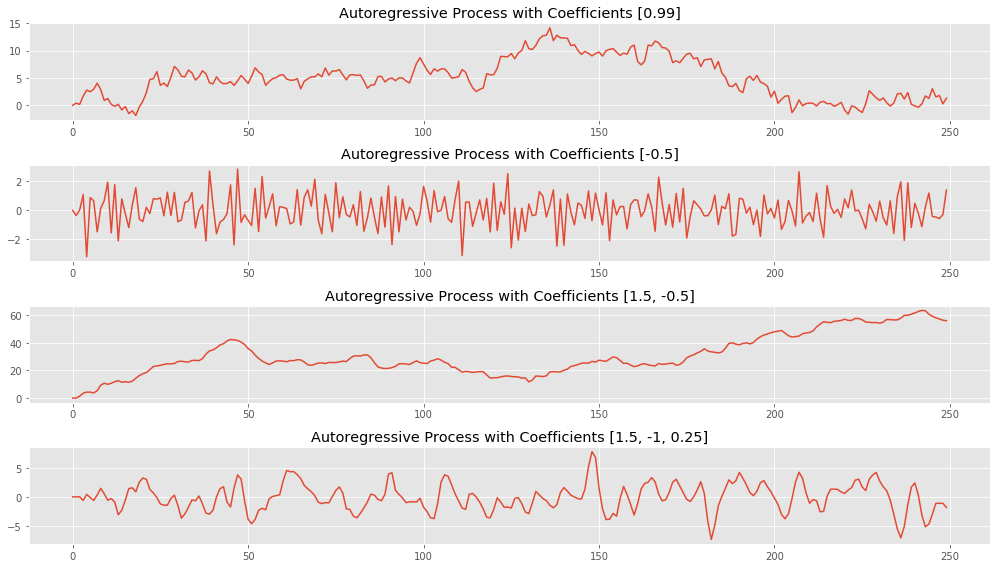

In [70]:
ar_coefs = [[0.99], [-0.5], [1.5, -0.5], [1.5, -1, 0.25]]

fig, axs = plt.subplots(4, figsize=(14, 8))

for i, (ax, coefs) in enumerate(zip(axs, ar_coefs)):
    plot_autoregressive_process(ax, 250, coefs)
    ax.set_title("Autoregressive Process with Coefficients {}".format(str(list(coefs))))

plt.tight_layout()

**Discussion:** What will the autocorrelation of an AR series look like?

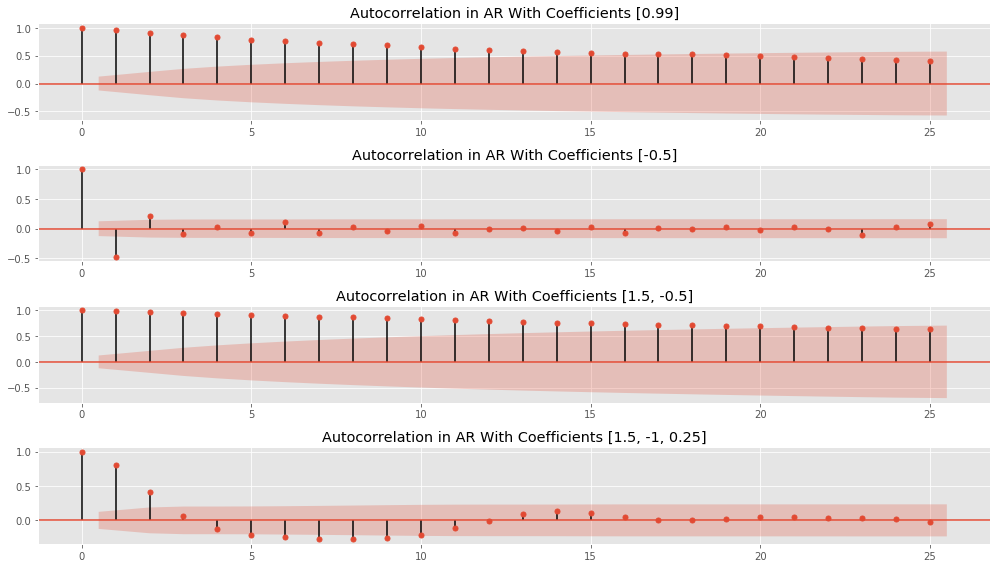

In [71]:
fig, axs = plt.subplots(4, figsize=(14, 8))

for i, (ax, coef) in enumerate(zip(axs, ar_coefs)):
    series = auto_regressive_process(size=250, coefs=coef)
    _ = sm.graphics.tsa.plot_acf(series, lags=25, ax=ax)
    ax.set_title("Autocorrelation in AR With Coefficients {}".format(str(list(coef))))
    
plt.tight_layout()

In an AR process, even thought subsequent data points are only *directly* influenced by a few previous data points, the influence tends to linger for a long time.

We can see this lingering influence in:
  - The gradual decrease in autocorrelation when the initial coefficient is positive.
  - The sinusoidal behaviour when there is negative coefficients.

For AR processes, controlling for this lingering influence with a *partial* autocorrelation plot is important.

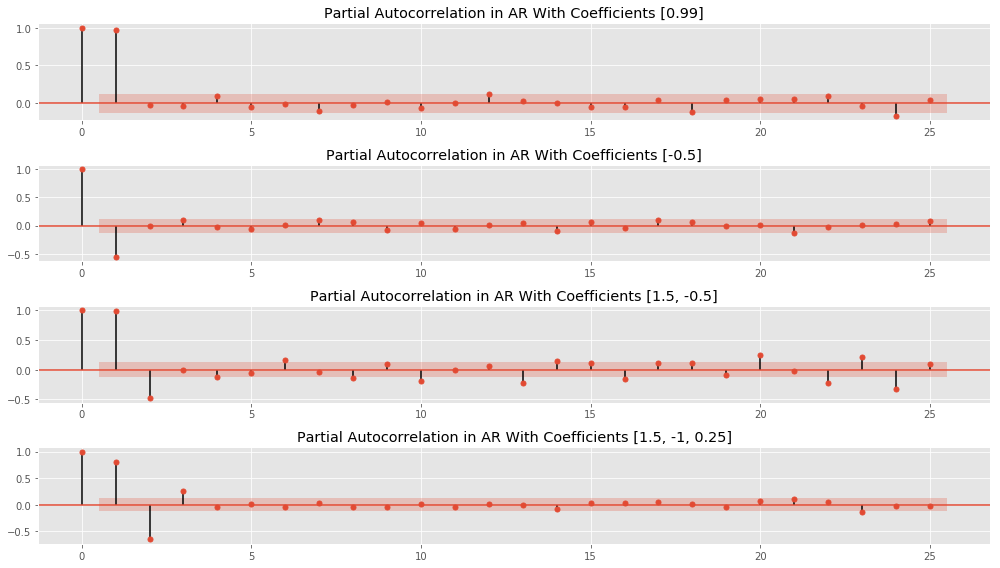

In [72]:
fig, axs = plt.subplots(4, figsize=(14, 8))

for i, (ax, coef) in enumerate(zip(axs, ar_coefs)):
    series = auto_regressive_process(size=250, coefs=coef)
    _ = sm.graphics.tsa.plot_pacf(series, lags=25, ax=ax)
    ax.set_title("Partial Autocorrelation in AR With Coefficients {}".format(str(list(coef))))
    
plt.tight_layout()

In the partial autocorrelation plot, we see very distinctly that the number of significant spikes is directly influenced by the number of non-zero coefficients.

### AR Models

Given stationary time series data, a reasonable question to ask is the following:
    
> Which AR series would be most likely to generate this data?

This is the concept behind AR models.

In [73]:
def fit_ar_model(series, order):
    # ARIMA is a more general model, which we are going to build up
    # in pieces.
    model = ARIMA(series, order=(order, 0, 0))
    return model.fit()

Let's generate some AR data, fit some AR models, then compare the coefficients.

In [74]:
for coef in ar_coefs:
    ar_series = auto_regressive_process(size=250, coefs=coef)
    ar_model = fit_ar_model(ar_series.values, order=(len(coef)))
    print("True Coefficients: {0: <26} Estimated Coefficients: {1: <26}".format(
            str(format_list_of_floats(coef)),
            str(format_list_of_floats(ar_model.params[1:]))))

True Coefficients: ['0.99']                   Estimated Coefficients: ['0.96']                  
True Coefficients: ['-0.50']                  Estimated Coefficients: ['-0.49']                 
True Coefficients: ['1.50', '-0.50']          Estimated Coefficients: ['1.51', '-0.51']         
True Coefficients: ['1.50', '-1.00', '0.25']  Estimated Coefficients: ['1.38', '-0.91', '0.19'] 


Just like for MA models, it looks like out AR models recover the true coefficients from an AR process.

### ARMA Models

Now that we have discussed AR and MA models, we can *combine* them into ARMA models, which have both AR and MA components.

ARMA models have both:
  - A **linear combination of white noise** component (the MA), where subsequent values of the series are (partially) a linear combination of white noise.
  - An **autoregressive component** the (AR), where subsequent values of the series are (partially) a linear combination of previous terms, plus noise.

  
$$ y_i = \mu + \overbrace{w_i + a_1 w_{i-1} + \cdots + a_k w_{i-k}}^{\text{MA component}} + \overbrace{b_1 y_{i-1} + b_2 y_{i-2} + \cdots + b_k y_{i-k} + \epsilon_i}^{\text{AR component}} $$

### ARIMA Models

The **I** in ARIMA stands for **integrated**.

The word *integration* is used here as the opposite of *difference*.

**Recall:** We often have to take the *first differences* of series we find in nature to make then *stationary*.


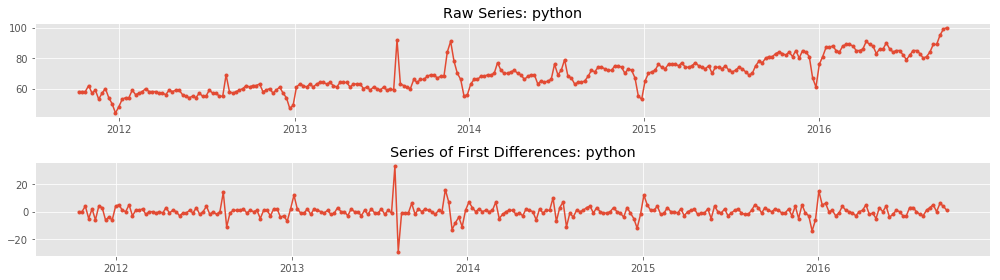

In [75]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, google_trends['python'], 'python')
fig.tight_layout()

MA and AR (and, consequently ARMA) models *only apply to* stationary series.

So to model series in nature, we often have to model the *differenced* series as an ARMA process.

This leads us, finally, to **ARIMA**.

An **ARIMA(p, d, q)** model:
  - Applies an ARMA model to a series that has been differenced $d$ times.
  - The AR part of the ARMA model has order $p$.
  - The MA part of the ARMA model has order $q$.

Let's explore generating some data as an ARIMA process.

In [76]:
def arima_process(size, ar_coefs, ma_coefs, d=0):
    """Simulate a series from an arima model."""
    arma = ArmaProcess(ar_coefs, ma_coefs)
    arma_series = arma.generate_sample(size + d)
    # Integrate d times.
    for i in range(d):
        arma_series = np.cumsum(arma_series)
    return pd.Series(arma_series)

In [77]:
def plot_arima_process(ax, size, ar_coefs, ma_coefs, d=0):
    series = arima_process(size, ar_coefs, ma_coefs, d)
    ax.plot(series.index, series)

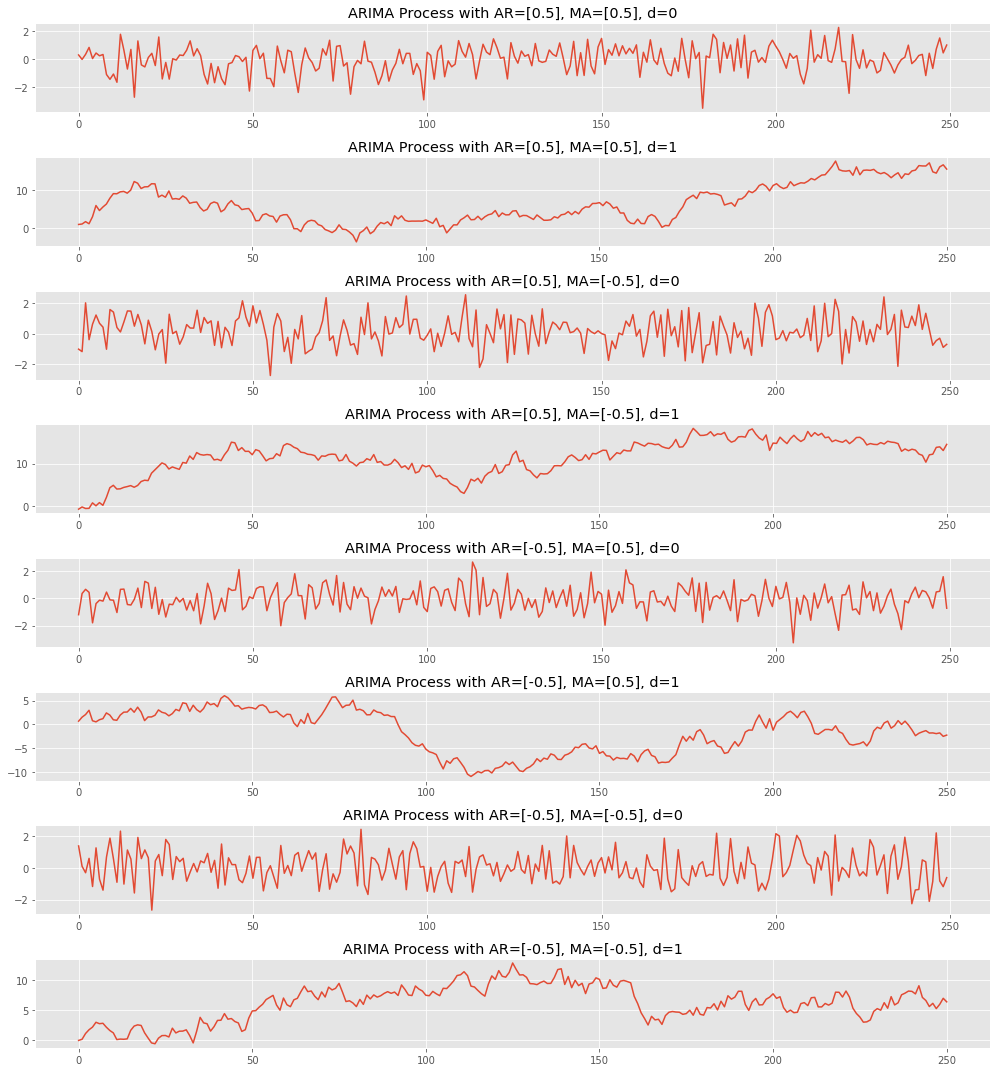

In [78]:
ar_coefs = [[0.5], [-0.5]]
ma_coefs = [[0.5], [-0.5]]
ds = [0, 1]

fig, axs = plt.subplots(8, figsize=(14, 15))

for ax, (ar, ma, d) in zip(axs, itertools.product(ar_coefs, ma_coefs, ds)):
    plot_arima_process(ax, 250, ar, ma, d)
    ax.set_title("ARIMA Process with AR={}, MA={}, d={}".format(
        str(list(ar)), str(list(ma)), d))
    
plt.tight_layout()

And, one final time, fitting an ARIMA model recovers the coefficients of a simulated ARIMA process.

### Case Study:  Electrical Equipment Orders Data

Let's attempt to fit an ARIMA model to a series of electrical orders, and use it to forecast future values.

In [79]:
file_name = 'data/elec-equip.csv'
df = pd.read_csv(file_name)
electric_series = pd.Series(df['x'].values, 
                            pd.DatetimeIndex(start='01-1996', end='12-2011', freq='M'))

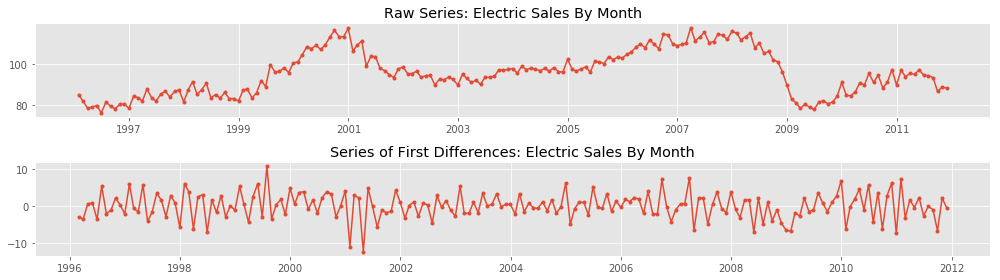

In [80]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, electric_series, "Electric Sales By Month")
plt.tight_layout()

The original series is clearly **not** stationary, so we differenced it.  The resulting series looks stationary, but let's use a test to check.

In [81]:
electric_differences = electric_series.diff()[1:]
test = sm.tsa.stattools.adfuller(electric_differences)
print("ADF p-value for differenced electric series: {0:2.2f}".format(test[1]))

ADF p-value for differenced electric series: 0.00


So the differenced series is stationary, and we can attempt to model it as an ARMA process.

We need to determine the correct order for the AR and MA models, so let's look at the auto and partial auto correlation plots.

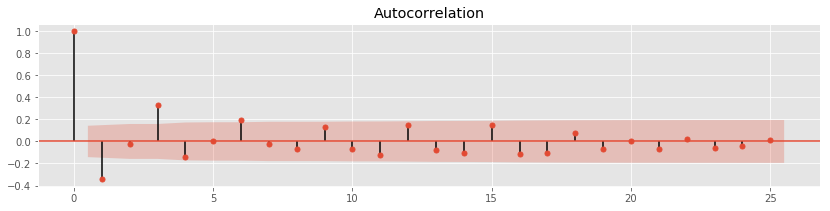

In [82]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(electric_differences, lags=25, ax=ax)

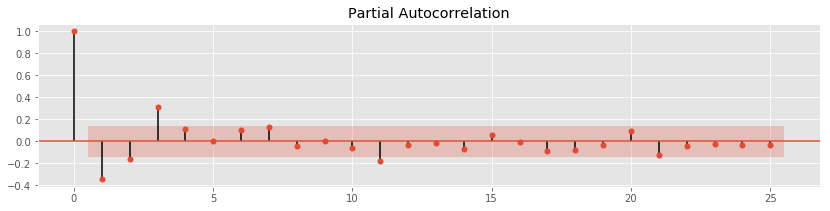

In [83]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(electric_differences, lags=25, ax=ax)

We see the following evidence:
  - Oscillatory behaviour in the autocorrelation plot.
  - Three significant partial autocorrelations at the beginning of the plot.
  
This suggests that the differenced series may be well modeled as an $AR(3)$ series.

Since we applied *one* difference to achieve stationarity, this suggests that we should model the *original* series as an $ARIMA(3, 1, 0)$.

In [84]:
electric_model = ARIMA(electric_series, order=(3, 1, 0)).fit()

In [85]:
print("ARIMA(3, 1, 0) coefficients from Electric model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    electric_model.params[0], 
        format_list_of_floats(list(electric_model.params[1:]))
    ))

ARIMA(3, 1, 0) coefficients from Electric model:
  Intercept 0.01
  AR ['-0.35', '-0.04', '0.31']


Let's simulate some data using these coefficients and see if it looks like our differenced data.

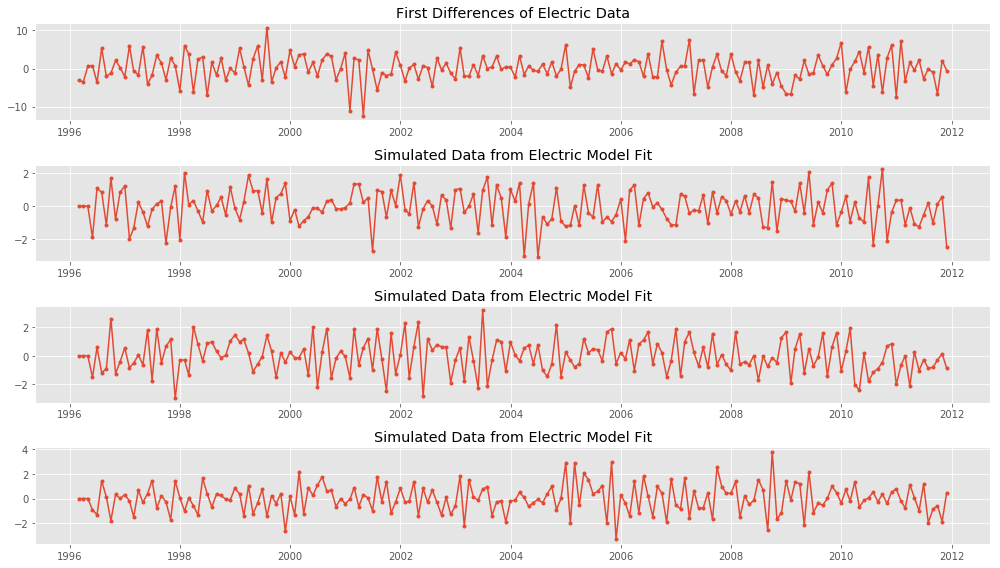

In [86]:
fig, ax = plt.subplots(4, figsize=(14, 8))

ax[0].plot(electric_differences.index, electric_differences, marker='.')
ax[0].set_title("First Differences of Electric Data")

for i in range(1, 4):
    simulated_data = auto_regressive_process(len(electric_differences), 
                                             np.array(list(electric_model.params)[1:]))
    simulated_data.index = electric_differences.index
    ax[i].plot(simulated_data.index, simulated_data, marker='.')
    ax[i].set_title("Simulated Data from Electric Model Fit")
    
plt.tight_layout()

We can also use the fit model to project electric sales into the future.

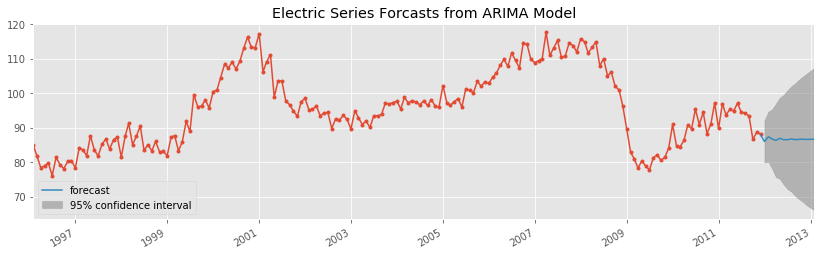

In [87]:
electric_series.reindex(pd.DatetimeIndex(start='01-1996', end='12-2012', freq='M'))

fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(electric_series.index, electric_series, marker='.')
fig = electric_model.plot_predict('2011-11-30', '2013', 
                                  dynamic=True, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Electric Series Forcasts from ARIMA Model")

Zooming in, we can see that we **have** done a bit better than the naive forecast of predicting the last observed value.

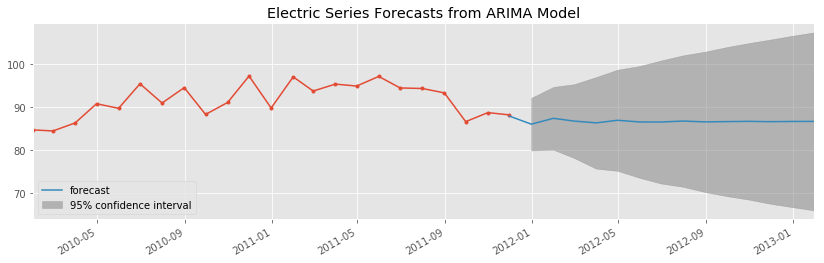

In [88]:
electric_series.reindex(pd.DatetimeIndex(start='01-1996', end='12-2012', freq='M'))

fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(electric_series['2010':].index, electric_series['2010':], marker='.')
fig = electric_model.plot_predict('2011-11-30', '2013', 
                                  dynamic=True, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Electric Series Forecasts from ARIMA Model")

If our model is good, the residuals should have no patterns whatsoever, i.e. be *white noise*

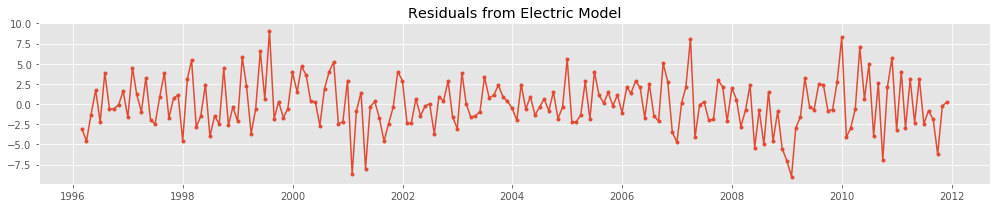

In [89]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(electric_model.resid.index, electric_model.resid, marker='.')
ax.set_title("Residuals from Electric Model")
plt.tight_layout()

One way to diagnose this is to check if any autocorrelation remains in the residuals.

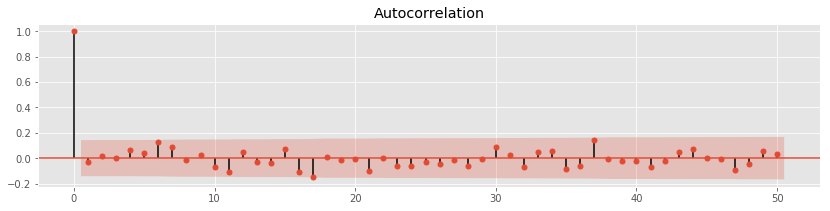

In [90]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(electric_model.resid, lags=50, ax=ax)

All the autocorrelations are within the confidence bands, so it looks like our model fits the data well.

### Model Selection: AIC

We made our selection of model based on the autocorrelation and partial autocorrelation plot, which is a good first step.

The overall procedure we followed is called the **Box-Jenkins Method**.

[Hyndman](https://robjhyndman.com/hyndsight/) recommends also trying a few models that are "close by", varying the ARMA parameters slightly, and then selecting the best model from the results using an information criteria.

In [91]:
parameters = [
    {'AR': 3, 'MA': 0},
    {'AR': 2, 'MA': 0},
    {'AR': 4, 'MA': 0},
    {'AR': 3, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(electric_series, order=(params['AR'], 1, params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

ARIMA(3, 1, 0) AIC: 981.3303854136205
ARIMA(2, 1, 0) AIC: 998.6531703177493
ARIMA(4, 1, 0) AIC: 980.9046395880097
ARIMA(3, 1, 1) AIC: 980.1617162814434


The $ARIMA(3, 1, 1)$ model has a *slightly* better AIC, so following Hyndmann, we would select this as our final model.

The overall methodology for producing an ARIMA model is summarized in the following flowchart, taken from Hyndmann.

![Hyndmann Modeling Process](images/arimaflowchart.png)

### Case Study: Baseball Searches

Let's complete our day with one more case study, the baseball search series we have been referencing the entire day.

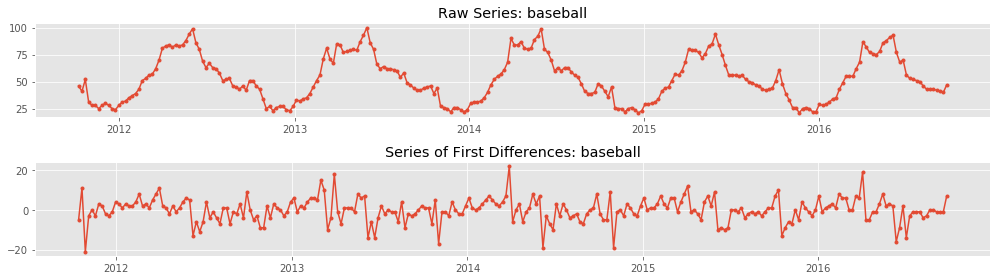

In [92]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, google_trends['baseball'], 'baseball')
fig.tight_layout()

Recall that the differenced series **was** found to be stationary by the ADF test, but the partial autocorrelation plot had a curious feature.

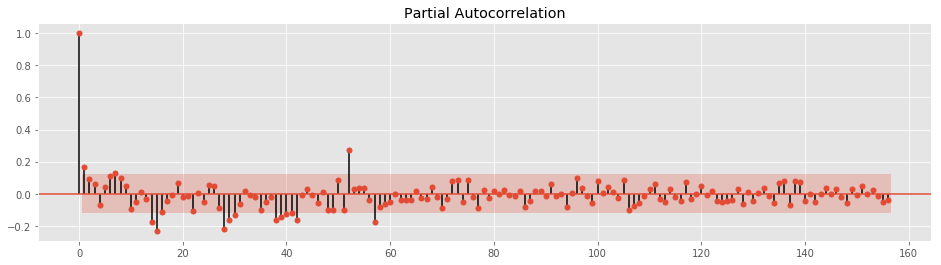

In [93]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(baseball_diff, lags=3*52, ax=ax, method='ywm')

That spike at $52$ weeks is something we don't know how to deal with yet!

There is a generalization of ARIMA that handles seasonality, which is included in the (development) version of `statsmodels` as SARIMAX.  The seasonal ARIMA model fits sub-ARIMA models to each seasonal sequence of data.

A seasonal ARIMA model has more parameters

$$ SARIMA(p, d, q)(sp, sd, sq)_k$$

The $p$, $d$, and $q$ indices mean exactly the same thing as before.

The $k$ is the length of a season, i.e., the observation window that exhibits periodic behaviour.

In our example we observe the following:
  - The seasonal behaviour in the partial autocorrelation plot happens at $52$ weeks.
  - There is only *one* significant seasonal partial autocorrelation.
  - There is only *one* significant initial partial autocorrelation.

Altogether, this means that an appropriate model would be a

$$ SARIMA(1, 1, 0)(1, 0, 0)_{52} $$

In [94]:
baseball_series = google_trends['baseball']

baseball_model = SARIMAX(baseball_series, 
                         order=(1, 1, 0), 
                         seasonal_order=(1, 0, 0, 52)).fit()

/home/moses/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)


Let's check the residuals for white noise'ness

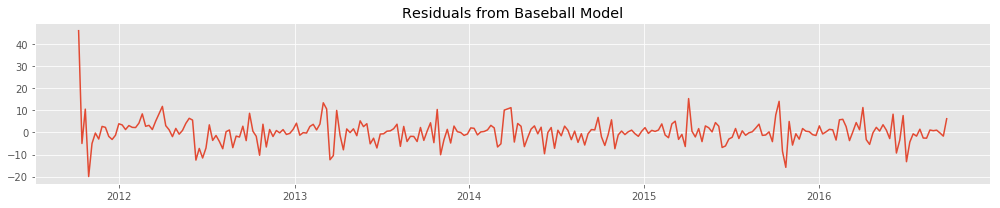

In [95]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(baseball_model.resid.index, baseball_model.resid)
ax.set_title("Residuals from Baseball Model")
plt.tight_layout()

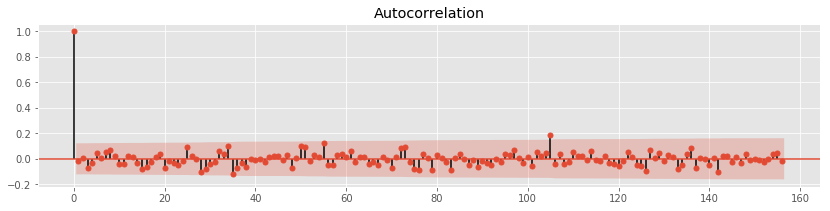

In [96]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(baseball_model.resid, lags=3*52, ax=ax)

There is one significant autocorrelation, but we expect at least a couple due to random chance, so this is satisfying.

To wrap up, let's see how the forecasts look.

In [97]:
# Pandas is a bit fussy about reindexing here, we need to extend the dates but
# Pandas's weekly series does not align with google's.
baseball_series.index = pd.DatetimeIndex(start='10-7-2011', end='9-25-2016', freq='W')
baseball_series = baseball_series.reindex(pd.DatetimeIndex(
        start='10-7-2011', end='2020', freq='W'))

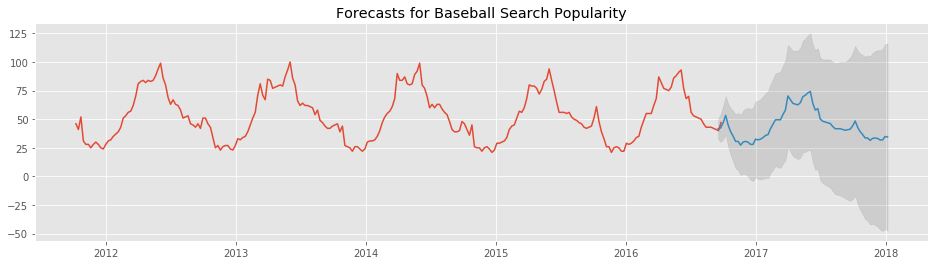

In [98]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(baseball_series.index, baseball_series)

results = baseball_model.get_prediction('2016-09-17', '2018', 
                   dynamic=True, ax=ax, plot_insample=False)
preds = results.predicted_mean
ci = results.conf_int()

ax.plot(preds.index, preds)
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
ax.set_title("Forecasts for Baseball Search Popularity");

In [99]:
baseball_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           baseball   No. Observations:                  260
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 52)   Log Likelihood                -777.532
Date:                            Tue, 06 Nov 2018   AIC                           1561.063
Time:                                    15:07:09   BIC                           1571.734
Sample:                                10-08-2011   HQIC                          1565.354
                                     - 09-24-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0960      0.043     -2.233      0.026      -0.180      -0.012
ar.S.L52       0.6514      0.035     18.652      0.000       0.583       0.720
sigma2        21.2282      1.406     15.094      0.000      18.472      23.985
===================================================================================
Ljung-Box (Q):                       38.39   Jarque-Bera (JB):                27.20
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.06
Prob(H) (two-sided):                  0.96   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""